# Binary classfication

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn import model_selection

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
import string
import re
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn import pipeline, cross_validation, preprocessing, metrics, grid_search
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Home task: Spam detection

Для заданной тестовой выборки построить модель для предсказания является ли sms сообщение спамом.  
На заданном разбиении (df_train, df_test) ваша модель должна превзойти baseline'ы, приведенные ниже.  

Чем больше baseline'ов вы превзойдете, тем выше ваша оценка
Метрика качества F1


baseline 1: 0.9444      bag of words + Multinomial Naive Bayes  
baseline 2: 0.9490      symbol 3-grams with IDF and l2-norm + Logistic Regression  
baseline 3: 0.9636      text stemming + baseline 2  


! Your results must be reproducible. Если ваша модель - стохастическая (как например LogisticRegression), то вы явно должны задавать все seed и random_state в параметрах моделей  
! Вы должны использовать df_test только для измерения качества конечной обученной модели. 

In [3]:
#load dataset
df = pd.read_csv('spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]
df = df.rename(columns={'v1': 'target', 'v2': 'text'})
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# dataset size
df.shape

(5572, 2)

In [5]:
# class proportions
df.target.value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: target, dtype: float64

In [6]:
# Use  df_train for model training
# Use df_test as  hold-out dataset for your final model perfomance estimation.
# You cannot change  this splitting
# All results must be reproducible
SEED = 1337
df_train, df_test = model_selection.train_test_split(df, test_size=0.4, random_state=SEED, shuffle=True, stratify=df.target)
print('train size %d, test size %d' % (df_train.shape[0], df_test.shape[0]))

train size 3343, test size 2229


In [7]:
# baseline 1
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder  

# build binary feature matrix from BoW model
vec = TfidfVectorizer(lowercase=True, analyzer='word', ngram_range=(1,1), norm=None, use_idf=False, binary=True)
X = vec.fit_transform(df_train.text)
print('feature matrix shape', X.shape)

# encode class labels
label_enc = LabelEncoder().fit(df_train.target)
y_train = label_enc.transform(df_train.target)

# fit our prediction model

model = MultinomialNB(alpha=1.0)
model.fit(X, y_train)
print('train', metrics.f1_score(y_train, model.predict(X)))

# perfomance on test dataset
X_test = vec.transform(df_test.text)
y_pred = model.predict(X_test)
y_test = label_enc.transform(df_test.target)
print('train', metrics.f1_score(y_test, model.predict(X_test)))

feature matrix shape (3343, 6629)
train 0.9774774774774775
train 0.9444444444444444


In [8]:
# baseline 2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV


# build feature matrix from 3-grams
# with l2-normalization and smoothed idf - look in docs for more details
vec = TfidfVectorizer(lowercase=True, analyzer='char', ngram_range=(3,3), norm='l2', use_idf=True, smooth_idf=True)
X = vec.fit_transform(df_train.text)
print('feature matrix shape', X.shape)

#encode labels
label_enc = LabelEncoder().fit(df_train.target)
y_train = label_enc.transform(df_train.target)

# Logistic Regression classifier has several hyperparams
# Optimize C (coeff before regularizer) and penalty (type of regularizer) using crossvalidation with grid search
# Basically it means it will look over every combination of hyperparams in the specified region (or lattice)
# and return the best one. 
# Look in docs  for more details
grid = GridSearchCV(LogisticRegression(random_state=SEED), # our model 
                   param_grid={'C': np.logspace(0,5,20), # C in lattice [10^0...10^5]
                               'penalty': ['l1', 'l2']}, 
                    scoring='f1', # our perfomance measure 
                    n_jobs=-1, # multithread 
                    cv=5, # 5-fold stratified cross-validation 
                    verbose=True, return_train_score=True)

grid.fit(X, y_train)
print('best params', grid.best_params_)
print('best estimator', grid.best_score_)
model = grid.best_estimator_

# grid.best_estimator_ is already fitted on whole train dataset
print('train', metrics.f1_score(y_train, model.predict(X)))

# perfomance on test dataset
X_test = vec.transform(df_test.text)
y_pred = model.predict(X_test)
y_test = label_enc.transform(df_test.target)
print('test', metrics.f1_score(y_test, model.predict(X_test)))

feature matrix shape (3343, 11830)
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.6s finished


best params {'C': 54555.947811685146, 'penalty': 'l2'}
best estimator 0.9460712426581742
train 1.0
test 0.9490333919156415


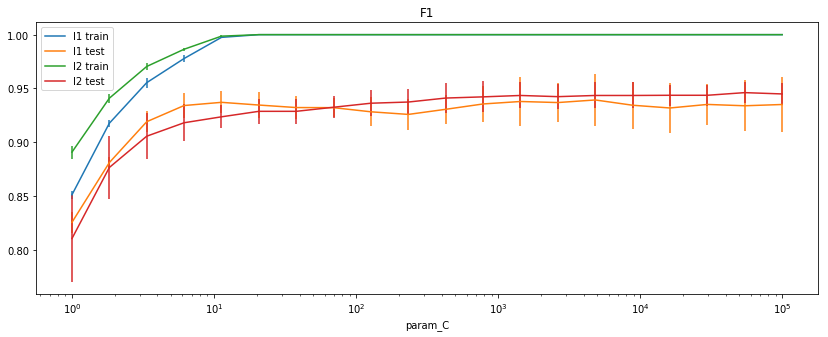

In [9]:
# validation curves
grid_df = pd.DataFrame(grid.cv_results_);
grid_df = grid_df[['param_C', 'param_penalty', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]
fig, ax = plt.subplots(figsize=(14,5))
for label, df in grid_df.groupby('param_penalty'):
    df.plot(x='param_C', y='mean_train_score', yerr='std_train_score', logx=True, label=label + ' train',
            ax=ax)
    df.plot(x='param_C', y='mean_test_score', yerr='std_test_score', logx=True, label=label + ' test',
            ax=ax)
    plt.title('F1')

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
# baseline 3

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import string
import re


stemmer = SnowballStemmer("english")
regex = re.compile('[%s]' % re.escape(string.punctuation))

# basic preprocessing
# make lowercase, remove punctuation and make stemming
def text_process(text):
    text = text.lower()
    text = regex.sub(' ', text)
    text = [stemmer.stem(word) for word in text.split() if word not in stopwords.words('english')]
    return " ".join(text)


df_train['text2'] = df_train.text.apply(text_process)
df_test['text2'] = df_test.text.apply(text_process)
df_train.head()

# build feature matrix from 3-grams
vec = TfidfVectorizer(lowercase=True, analyzer='char', ngram_range=(3,3), 
                      min_df=10, # exclude 3-grams appeared in less then 10 messages. 
                      use_idf=True)
X = vec.fit_transform(df_train.text2)
print('feature matrix shape', X.shape)

#encode labels
label_enc = LabelEncoder().fit(df_train.target)
y_train = label_enc.transform(df_train.target)

# optimize  hyperparams
grid = GridSearchCV(LogisticRegression(random_state=SEED), 
                   param_grid={'C': np.logspace(0,5,10), 
                               'penalty': ['l1', 'l2']}, 
                    scoring='f1', n_jobs=-1, cv=5, verbose=True, return_train_score=True)

grid.fit(X, y_train)
print(grid.best_params_)
print(grid.best_score_)
model = grid.best_estimator_
print('train', metrics.f1_score(y_train, model.predict(X)))

X_test = vec.transform(df_test.text2)
y_pred = model.predict(X_test)
y_test = label_enc.transform(df_test.target)
print('test', metrics.f1_score(y_test, model.predict(X_test)))

feature matrix shape (3343, 2393)
Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'C': 100000.0, 'penalty': 'l2'}
0.9440632976282287
train 1.0
test 0.9636048526863085


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished


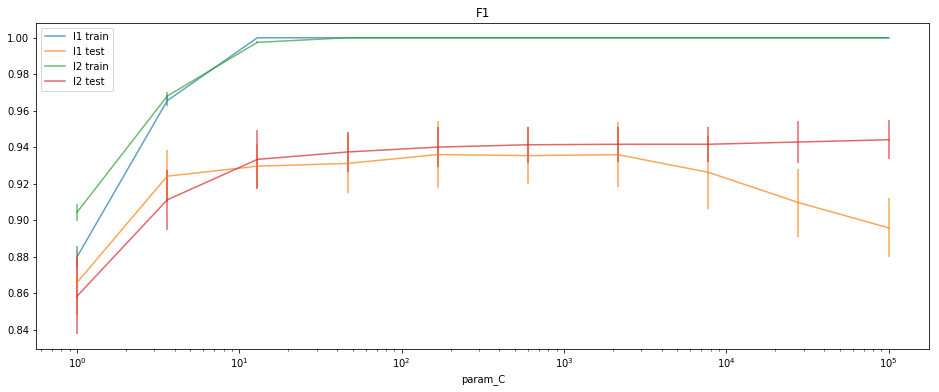

In [12]:
# validation curves
grid_df = pd.DataFrame(grid.cv_results_);
grid_df = grid_df[['param_C', 'param_penalty', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]
fig, ax = plt.subplots(figsize=(16,6))
for label, df in grid_df.groupby('param_penalty'):
    df.plot(x='param_C', y='mean_train_score', yerr='std_train_score', logx=True, label=label + ' train',
            alpha=0.7,
            ax=ax)
    df.plot(x='param_C', y='mean_test_score', yerr='std_test_score', logx=True, label=label + ' test',
            alpha=0.7,
            ax=ax)
    plt.title('F1')

###### Повышение качества

In [13]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]
df = df.rename(columns={'v1': 'target', 'v2': 'text'})

def clean(text):
    stop = set(stopwords.words('english'))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    porter= PorterStemmer()
    
    text=text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop))])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    stem = " ".join(porter.stem(token) for token in normalized.split())
    
    return (normalized, stem)

df['text_1'] = df['text'].apply(lambda x: clean(x)[0])
df['text_2'] = df['text'].apply(lambda x: clean(x)[1])

SEED = 1337
df_train, df_test = model_selection.train_test_split(df, test_size=0.4, random_state=SEED, shuffle=True, stratify=df.target)
print('train size %d, test size %d' % (df_train.shape[0], df_test.shape[0]))

train size 3343, test size 2229


In [14]:
vect_tfidf_word = TfidfVectorizer(analyzer='word', use_idf=True)
X_train_word = vect_tfidf_word.fit_transform(df_train['text_2'])
X_test_word = vect_tfidf_word.transform(df_test['text_2'])

label_enc = LabelEncoder().fit(df_train.target)
y_train = label_enc.transform(df_train.target)
y_test = label_enc.transform(df_test.target)


parameters = [{'C': np.logspace(-10,5,20), 'penalty': ['l1','l2'],
                               'tol':np.logspace(-6,-4,3)}]
clf = LogisticRegression(random_state= SEED)
skf = cross_validation.StratifiedKFold(y_train, n_folds=5)

gs_word = GridSearchCV(clf, parameters, cv=skf, scoring='f1')
gs_word.fit(X_train_word, y_train)
print(gs_word.best_estimator_)
print('best f1_score', gs_word.best_score_)

clf_word = gs_word.best_estimator_ 
clf_word.fit(X_train_word, y_train)

print()
y_pred = clf_word.predict(X_test_word)
score = f1_score(y_pred, y_test)
print('f1 score test', score)
print(classification_report(y_pred, y_test))
print(confusion_matrix(y_pred, y_test))



score_best1 = 0.9444
score_best2 = 0.9490
score_best3 = 0.9636
print('\n')
if score > score_best1 and score < score_best2:
    print(score, '>' , score_best1, score > score_best1)
    print('WIN score_best1!')
elif score > score_best2 and score < score_best3:
    print(score, '>' , score_best2, score > score_best2)
    print('WIN score_best2!')
elif score > score_best3:
    print(score, '>' , score_best3, score > score_best3)
    print('WIN score_best3!')
    

LogisticRegression(C=16237.767391887242, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=1337,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
best f1_score 0.8971304908047233

f1 score test 0.9462738301559791
             precision    recall  f1-score   support

          0       1.00      0.99      0.99      1951
          1       0.91      0.98      0.95       278

avg / total       0.99      0.99      0.99      2229

[[1925   26]
 [   5  273]]


0.9462738301559791 > 0.9444 True
WIN score_best1!


In [15]:
vect_tfidf_char= TfidfVectorizer(analyzer='char', ngram_range=(2, 3), use_idf=True)
X_train_char = vect_tfidf_char.fit_transform(df_train['text_2'])
X_test_char = vect_tfidf_char.transform(df_test['text_2'])

label_enc = LabelEncoder().fit(df_train.target)
y_train = label_enc.transform(df_train.target)
y_test = label_enc.transform(df_test.target)

parameters = [{'C': np.logspace(-10,5,20), 'penalty': ['l1','l2'],
                               'tol':np.logspace(-6,-4,3)}]
clf = LogisticRegression(random_state= SEED)
skf = cross_validation.StratifiedKFold(y_train, n_folds=4)

gs_char = GridSearchCV(clf, parameters, cv=skf, scoring='f1')
gs_char.fit(X_train_char, y_train)
print(gs_char.best_estimator_)
print('best f1_score', gs_char.best_score_)

clf_char = gs_char.best_estimator_ 
clf_char.fit(X_train_char, y_train)

print()
y_pred = clf_char.predict(X_test_char)
score = f1_score(y_pred, y_test)
print('f1 score test', score)
print(classification_report(y_pred, y_test))
print(confusion_matrix(y_pred, y_test))


score_best1 = 0.9444
score_best2 = 0.9490
score_best3 = 0.9636
print('\n')
if score > score_best1 and score < score_best2:
    print(score, '>' , score_best1, score > score_best1)
    print('WIN score_best1!')
elif score > score_best2 and score < score_best3:
    print(score, '>' , score_best2, score > score_best2)
    print('WIN score_best2!')
elif score > score_best3:
    print(score, '>' , score_best3, score > score_best3)
    print('WIN score_best3!')

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=1337,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
best f1_score 0.9273321698935822

f1 score test 0.9488054607508534
             precision    recall  f1-score   support

          0       1.00      0.99      0.99      1942
          1       0.93      0.97      0.95       287

avg / total       0.99      0.99      0.99      2229

[[1921   21]
 [   9  278]]


0.9488054607508534 > 0.9444 True
WIN score_best1!


In [16]:
m_ = 0
score_ = 0
a_ = 0
b_ = 0
for a in np.arange(0.1, 1., 0.1):
    for b in np.arange(0.1, 1., 0.1):
        y_pred_prob = clf_word.predict_proba(X_test_word)[:,1] * a + clf_char.predict_proba(X_test_char)[:,1] *b

        for m in np.arange(0.0, 1.01, 0.01):
            y_pred = (y_pred_prob > m).astype(int)
            score = metrics.f1_score(y_test, y_pred)
            if score >= score_:
                score_ = score
                m_ = m
                a_ = a
                b_ = b

print('a:', a_, 'b:', b_, 'm:', m_ , 'score:', score_)
        
        
score = score_
score_best1 = 0.9444
score_best2 = 0.9490
score_best3 = 0.9636
print('\n')
if score > score_best1 and score < score_best2:
    print(score, '>' , score_best1, score > score_best1)
    print('WIN score_best1!')
elif score > score_best2 and score < score_best3:
    print(score, '>' , score_best2, score > score_best2)
    print('WIN score_best2!')
elif score > score_best3:
    print(score, '>' , score_best3, score > score_best3)
    print('WIN score_best3!')

a: 0.7000000000000001 b: 0.6 m: 0.59 score: 0.9550173010380624


0.9550173010380624 > 0.949 True
WIN score_best2!


In [17]:
m_ = 0
score_ = 0
a_ = 0
b_ = 0
for a in np.arange(0.1, 1., 0.1):
    for b in np.arange(0.1, 1., 0.1):
        y_pred_prob = model.predict_proba(X_test)[:,1] * a + clf_char.predict_proba(X_test_char)[:,1] *b

        for m in np.arange(0.0, 1.01, 0.01):
            y_pred = (y_pred_prob > m).astype(int)
            score = metrics.f1_score(y_test, y_pred)
            if score >= score_:
                score_ = score
                m_ = m
                a_ = a
                b_ = b

print('a:', a_, 'b:', b_, 'm:', m_ , 'score:', score_)
        
        
score = score_
score_best1 = 0.9444
score_best2 = 0.9490
score_best3 = 0.9636
print('\n')
if score > score_best1 and score < score_best2:
    print(score, '>' , score_best1, score > score_best1)
    print('WIN score_best1!')
elif score > score_best2 and score < score_best3:
    print(score, '>' , score_best2, score > score_best2)
    print('WIN score_best2!')
elif score > score_best3:
    print(score, '>' , score_best3, score > score_best3)
    print('WIN score_best3!')

a: 0.9 b: 0.2 m: 0.59 score: 0.9653979238754326


0.9653979238754326 > 0.9636 True
WIN score_best3!
